# Importing Libraries

In [37]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
#import folium # map rendering library

print('Libraries imported.')

Libraries imported.


# Downloading New York data from link

In [38]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [39]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [40]:
neighborhoods_data = newyork_data['features']

In [41]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [42]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

# Neighborhood data of New York

In [43]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [44]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


In [45]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


# Neighborhood data of Queens Borough

In [46]:
queens_data = neighborhoods[neighborhoods['Borough'] == 'Queens'].reset_index(drop=True)
queens_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Queens,Astoria,40.768509,-73.915654
1,Queens,Woodside,40.746349,-73.901842
2,Queens,Jackson Heights,40.751981,-73.882821
3,Queens,Elmhurst,40.744049,-73.881656
4,Queens,Howard Beach,40.654225,-73.838138


In [47]:
address2 = 'Queens, NY'

geolocator2 = Nominatim(user_agent="ny_explorer")
location2 = geolocator.geocode(address)
latitude2 = location.latitude
longitude2 = location.longitude
print('The geograpical coordinate of Queens are {}, {}.'.format(latitude2, longitude2))

The geograpical coordinate of Queens are 40.7127281, -74.0060152.


#  Foursquare credentials

In [48]:
CLIENT_ID = '3USCXQEQM1121U1DMLPI3YUTTH2XZNEU5APRVQEBSZ3MXTJJ' # your Foursquare ID
CLIENT_SECRET = '3XNZ3RKUQBEJ100JVJRC2P25WMBZQ3SQ15E02BOXK0PPVQPY' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 3USCXQEQM1121U1DMLPI3YUTTH2XZNEU5APRVQEBSZ3MXTJJ
CLIENT_SECRET:3XNZ3RKUQBEJ100JVJRC2P25WMBZQ3SQ15E02BOXK0PPVQPY


In [49]:
queens_data.loc[0, 'Neighborhood']

'Astoria'

In [50]:
neighborhood_latitude = queens_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = queens_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = queens_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Astoria are 40.76850859335492, -73.91565374304234.


# Querying Foursquare API for venues in 500 meters of each neighborhood of Queens

In [51]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display UR

'https://api.foursquare.com/v2/venues/explore?&client_id=3USCXQEQM1121U1DMLPI3YUTTH2XZNEU5APRVQEBSZ3MXTJJ&client_secret=3XNZ3RKUQBEJ100JVJRC2P25WMBZQ3SQ15E02BOXK0PPVQPY&v=20180605&ll=40.76850859335492,-73.91565374304234&radius=500&limit=100'

In [52]:
results = requests.get(url).json()

In [53]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [54]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Favela Grill,Brazilian Restaurant,40.767348,-73.917897
1,Orange Blossom,Gourmet Shop,40.769856,-73.917012
2,Simply Fit Astoria,Gym,40.769114,-73.912403
3,CrossFit Queens,Gym,40.769404,-73.918977
4,Titan Foods Inc.,Gourmet Shop,40.769198,-73.919253


In [55]:
print('{} venues were returned by Foursquare for Astoria, Queens.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare for Astoria, Queens.


# Exploring venueus in neighborhoods of Queens

In [56]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [57]:
queens_venues = getNearbyVenues(names=queens_data['Neighborhood'],
                                   latitudes=queens_data['Latitude'],
                                   longitudes=queens_data['Longitude']
                                  )

Astoria
Woodside
Jackson Heights
Elmhurst
Howard Beach
Corona
Forest Hills
Kew Gardens
Richmond Hill
Flushing
Long Island City
Sunnyside
East Elmhurst
Maspeth
Ridgewood
Glendale
Rego Park
Woodhaven
Ozone Park
South Ozone Park
College Point
Whitestone
Bayside
Auburndale
Little Neck
Douglaston
Glen Oaks
Bellerose
Kew Gardens Hills
Fresh Meadows
Briarwood
Jamaica Center
Oakland Gardens
Queens Village
Hollis
South Jamaica
St. Albans
Rochdale
Springfield Gardens
Cambria Heights
Rosedale
Far Rockaway
Broad Channel
Breezy Point
Steinway
Beechhurst
Bay Terrace
Edgemere
Arverne
Rockaway Beach
Neponsit
Murray Hill
Floral Park
Holliswood
Jamaica Estates
Queensboro Hill
Hillcrest
Ravenswood
Lindenwood
Laurelton
Lefrak City
Belle Harbor
Rockaway Park
Somerville
Brookville
Bellaire
North Corona
Forest Hills Gardens
Jamaica Hills
Utopia
Pomonok
Astoria Heights
Hunters Point
Sunnyside Gardens
Blissville
Roxbury
Middle Village
Malba
Hammels
Bayswater
Queensbridge


In [58]:
print(queens_venues.shape)
queens_venues.head()

(2083, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Astoria,40.768509,-73.915654,Favela Grill,40.767348,-73.917897,Brazilian Restaurant
1,Astoria,40.768509,-73.915654,Orange Blossom,40.769856,-73.917012,Gourmet Shop
2,Astoria,40.768509,-73.915654,Simply Fit Astoria,40.769114,-73.912403,Gym
3,Astoria,40.768509,-73.915654,CrossFit Queens,40.769404,-73.918977,Gym
4,Astoria,40.768509,-73.915654,Titan Foods Inc.,40.769198,-73.919253,Gourmet Shop


# Grouping venues by Neighborhood

In [59]:
a=queens_venues.groupby('Neighborhood').count()
b=a.reset_index()

In [60]:
b.columns

Index(['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude',
       'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category'],
      dtype='object')

In [61]:
print('There are {} unique categories.'.format(len(queens_venues['Venue Category'].unique())))

There are 272 unique categories.


# Bar plot of Number of venues vs Neighborhood

<BarContainer object of 81 artists>

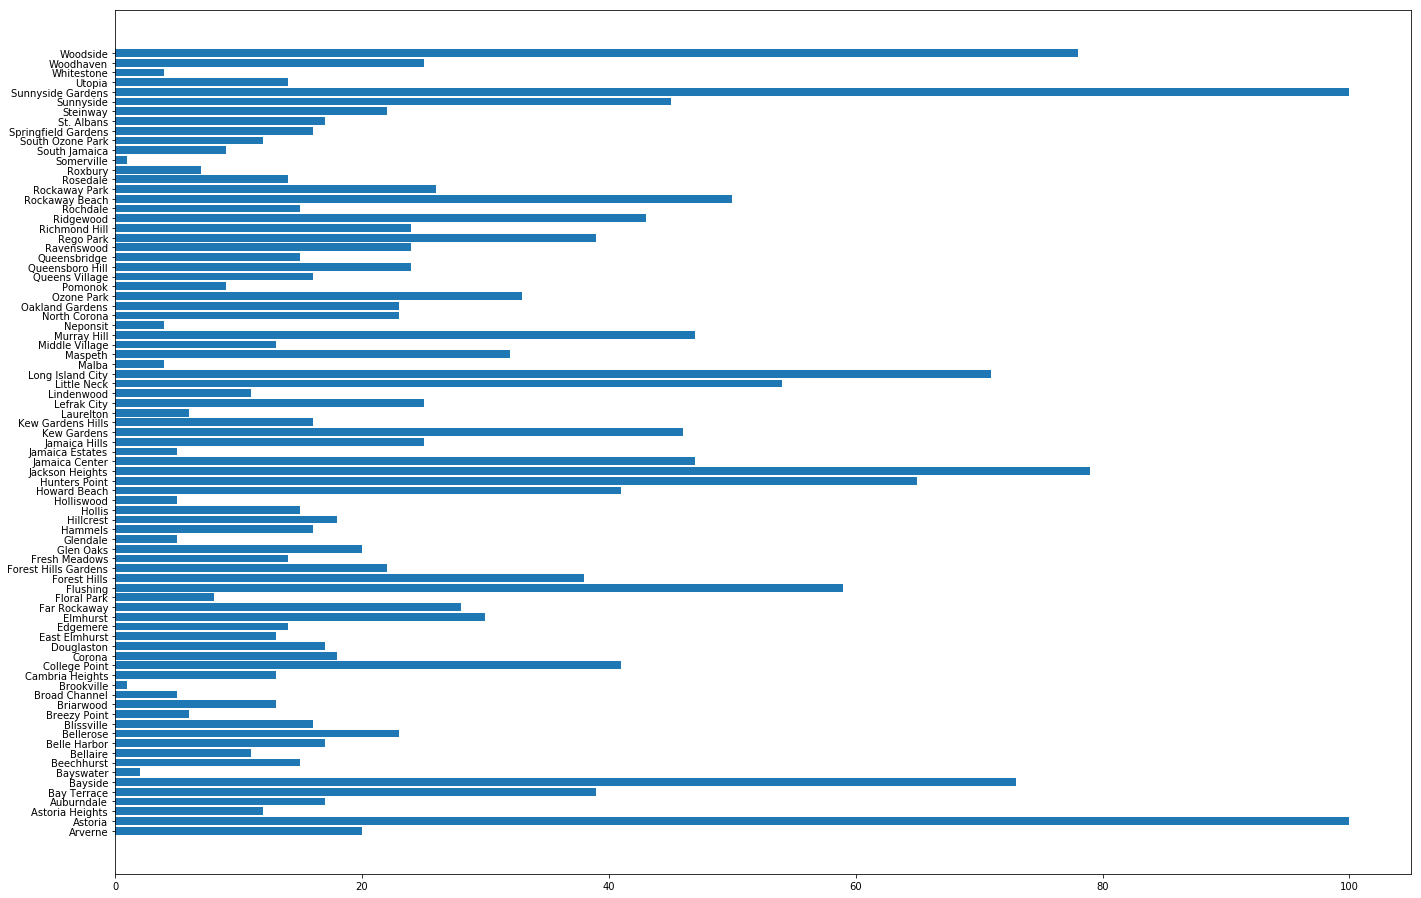

In [62]:
import matplotlib.pyplot as plt
fig=plt.figure()
ax=fig.add_axes([0,0,3,3])
ax.barh(b['Neighborhood'], b['Venue'])

# Analyzing each neighbourhood

In [63]:
# one hot encoding
queens_onehot = pd.get_dummies(queens_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
queens_onehot['Neighborhood'] = queens_venues['Neighborhood'] 
queens_onehot.head()

,Accessories Store,Afghan Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Garden,Bike Trail,Bistro,Board Shop,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,Colombian Restaurant,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dosa Place,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Hardware Store,Health & Beauty Service,Health Food Store,Himalayan Restaurant,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Other Great Outdoors,Other Nightlife,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pier,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Post Office,Pub,Ramen Restaurant,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Rock Club,Romanian Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,State / Provincial Park,Steakhouse,Storage Facility,Strip Club,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Women's Store,Y

In [64]:
# move neighborhood column to the first column
fixed_columns = [queens_onehot.columns[-1]] + list(queens_onehot.columns[:-1])
queens_onehot = queens_onehot[fixed_columns]

In [65]:
queens_onehot.shape

(2083, 272)

In [66]:
queens_grouped = queens_onehot.groupby('Neighborhood').sum().reset_index()

In [67]:
queens_grouped.shape

(81, 272)

# Removing Neighborhoods with Indian Restaurants

In [68]:
queens_grouped_new = queens_grouped[queens_grouped['Indian Restaurant']==0]
queens_grouped_new.reset_index()

,index,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Garden,Bike Trail,Bistro,Board Shop,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,Colombian Restaurant,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dosa Place,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Hardware Store,Health & Beauty Service,Health Food Store,Himalayan Restaurant,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Other Great Outdoors,Other Nightlife,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pier,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Post Office,Pub,Ramen Restaurant,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Rock Club,Romanian Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,State / Provincial Park,Steakhouse,Storage Facility,Strip Club,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center,Wine Bar,Wine Shop,Wings Joi

In [69]:
queens_grouped_new.shape

(68, 272)

# Feature selection: Beach, Bowling Alley, Flea Market, Metro station, Shopping Mall, Multiplex, Park, Scenic Lookout, Movie Theater

In [96]:
queens_grouped_new1=queens_grouped_new[['Neighborhood','Beach','Bowling Alley','Flea Market','Metro Station','Shopping Mall','Multiplex','Park','Scenic Lookout','Movie Theater']]
queens_grouped_new1.head()

,Neighborhood,Beach,Bowling Alley,Flea Market,Metro Station,Shopping Mall,Multiplex,Park,Scenic Lookout,Movie Theater
0,Arverne,1,0,0,2,0,0,0,0,0
2,Astoria Heights,0,1,0,0,0,0,0,0,0
3,Auburndale,0,0,0,0,0,0,0,0,0
4,Bay Terrace,0,0,0,0,1,0,0,0,1
6,Bayswater,0,0,0,0,0,0,0,0,0


In [97]:
queens_grouped_new1.shape

(68, 10)

In [98]:
queens_grouped_new1['Total']=queens_grouped_new1.sum(axis=1)

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [99]:
queens_grouped_new1.reset_index()

,index,Neighborhood,Beach,Bowling Alley,Flea Market,Metro Station,Shopping Mall,Multiplex,Park,Scenic Lookout,Movie Theater,Total
0,0,Arverne,1,0,0,2,0,0,0,0,0,3
1,2,Astoria Heights,0,1,0,0,0,0,0,0,0,1
2,3,Auburndale,0,0,0,0,0,0,0,0,0,0
3,4,Bay Terrace,0,0,0,0,1,0,0,0,1,2
4,6,Bayswater,0,0,0,0,0,0,0,0,0,0
5,7,Beechhurst,0,0,0,0,0,0,1,0,0,1
6,8,Bellaire,0,0,0,0,0,0,0,0,0,0
7,9,Belle Harbor,3,0,0,0,0,0,0,0,0,3
8,10,Bellerose,0,0,0,0,0,0,0,0,0,0
9,11,Blissville,0,0,0,0,0,0,0,0,1,1


# Considering only those neighborhoods for which atleast one feature venue is present

In [100]:
queens_grouped_new1 = queens_grouped_new1[queens_grouped_new1['Total']!=0]

In [101]:
x=queens_grouped_new1[['Neighborhood','Total']]

In [102]:
queens_grouped_new1.drop(['Total'],axis=1,inplace=True)

In [103]:
y=queens_grouped_new1

# Neighborhoods with Total no of venues and Total no of unique venues

In [104]:
y.loc[y['Bowling Alley']>1,'Bowling Alley']=1
y.loc[y['Beach']>1,'Beach']=1
y.loc[y['Flea Market']>1,'Flea Market']=1
y.loc[y['Metro Station']>1,'Metro Station']=1
y.loc[y['Shopping Mall']>1,'Shopping Mall']=1
y.loc[y['Multiplex']>1,'Multiplex']=1
y.loc[y['Park']>1,'Park']=1
y.loc[y['Scenic Lookout']>1,'Scenic Lookout']=1
y.loc[y['Movie Theater']>1,'Movie Theater']=1
x['Unique_Total']=y.sum(axis=1)
x

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Neighborhood,Total,Unique_Total
0,Arverne,3,2
2,Astoria Heights,1,1
4,Bay Terrace,2,2
7,Beechhurst,1,1
9,Belle Harbor,3,1
11,Blissville,1,1
12,Breezy Point,3,1
17,College Point,1,1
18,Corona,1,1
21,Edgemere,4,3


# k-means Clustering to identify ideal locations for Indian Fast food joint

In [105]:
x.reset_index()

,index,Neighborhood,Total,Unique_Total
0,0,Arverne,3,2
1,2,Astoria Heights,1,1
2,4,Bay Terrace,2,2
3,7,Beechhurst,1,1
4,9,Belle Harbor,3,1
5,11,Blissville,1,1
6,12,Breezy Point,3,1
7,17,College Point,1,1
8,18,Corona,1,1
9,21,Edgemere,4,3


# Scatter plot of Unique featured venues and Total featured venues

Text(0, 0.5, 'Unique featured venues')

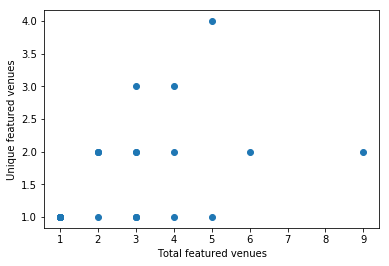

In [106]:
plt.scatter(x['Total'], x['Unique_Total'])
plt.xlabel('Total featured venues')
plt.ylabel('Unique featured venues')

In [107]:
from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

In [108]:
cl = x.values[:,1:]
cluster_dataset = StandardScaler().fit_transform(cl)
cluster_dataset

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[ 0.4002369 ,  0.80829038],
       [-0.70811143, -0.57735027],
       [-0.15393727,  0.80829038],
       [-0.70811143, -0.57735027],
       [ 0.4002369 , -0.57735027],
       [-0.70811143, -0.57735027],
       [ 0.4002369 , -0.57735027],
       [-0.70811143, -0.57735027],
       [-0.70811143, -0.57735027],
       [ 0.95441106,  2.19393102],
       [-0.15393727,  0.80829038],
       [-0.15393727, -0.57735027],
       [-0.70811143, -0.57735027],
       [ 1.50858523, -0.57735027],
       [ 0.95441106,  0.80829038],
       [ 1.50858523,  3.57957167],
       [-0.70811143, -0.57735027],
       [-0.70811143, -0.57735027],
       [-0.70811143, -0.57735027],
       [-0.70811143, -0.57735027],
       [-0.70811143, -0.57735027],
       [ 0.95441106, -0.57735027],
       [-0.70811143, -0.57735027],
       [ 0.4002369 ,  2.19393102],
       [-0.70811143, -0.57735027],
       [-0.15393727,  0.80829038],
       [ 3.72528188,  0.80829038],
       [ 2.06275939,  0.80829038],
       [-0.70811143,

# Creating 3 clusters

In [109]:
num_clusters = 4

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
k_means.fit(cluster_dataset)
labels = k_means.labels_

In [110]:
x["Labels"] = labels
x

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Neighborhood,Total,Unique_Total,Labels
0,Arverne,3,2,0
2,Astoria Heights,1,1,2
4,Bay Terrace,2,2,0
7,Beechhurst,1,1,2
9,Belle Harbor,3,1,0
11,Blissville,1,1,2
12,Breezy Point,3,1,0
17,College Point,1,1,2
18,Corona,1,1,2
21,Edgemere,4,3,1


In [111]:
x.groupby('Labels').mean()

,Total,Unique_Total
Labels,,
0,3.090909,1.545455
1,4.000000,3.333333
2,1.050000,1.000000
3,7.500000,2.000000


# scatter plot of given points(blue) and 3 clusters(red)

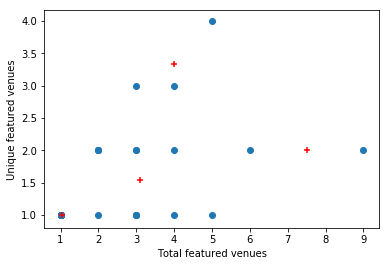

In [112]:
clusterx=[3.09,4,1.05,7.5]
clustery=[1.54,3.33,1,2]
plt.scatter(x['Total'], x['Unique_Total'])
plt.xlabel('Total featured venues')
plt.ylabel('Unique featured venues')
plt.scatter(clusterx,clustery,marker='+',color='red')

# List of neighborhoods sorted by clusters

In [113]:
x.sort_values(by=['Labels'])

,Neighborhood,Total,Unique_Total,Labels
0,Arverne,3,2,0
79,Woodhaven,3,2,0
33,Hollis,4,2,0
31,Hammels,5,1,0
59,Queensbridge,2,2,0
71,South Ozone Park,3,1,0
23,Far Rockaway,2,2,0
9,Belle Harbor,3,1,0
4,Bay Terrace,2,2,0
12,Breezy Point,3,1,0
